In [39]:
# general libraries
import pandas as pd
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

In [2]:
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cossim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

In [3]:
# !pwd

/Users/dpong/Data 620/data_620_su2021/data620/Assignments/FinalProject


In [4]:
# loading listing data

listing_df = pd.read_csv('listings_vancouver.csv',dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(4299, 74)

In [5]:
listing_df.head()

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,10080,https://www.airbnb.com/rooms/10080,20210412154228,2021-04-13,D1 - Million Dollar View 2 BR,"Stunning two bedroom, two bathroom apartment. ...",NaN,https://a0.muscache.com/pictures/55778229/c2f7...,30899,https://www.airbnb.com/users/show/30899,...,9,10,9,18-476608,f,40,40,0,0,0.14
1,13358,https://www.airbnb.com/rooms/13358,20210412154228,2021-04-13,Monthly (or Longer ) Designer One Bedroom Down...,<b>The space</b><br />This suites central loca...,NaN,https://a0.muscache.com/pictures/c23bb7ef-e300...,52116,https://www.airbnb.com/users/show/52116,...,10,10,9,18-611603,f,1,1,0,0,3.27
2,13490,https://www.airbnb.com/rooms/13490,20210412154228,2021-04-13,Vancouver's best kept secret,This apartment rents for one month blocks of t...,"In the heart of Vancouver, this apartment has ...",https://a0.muscache.com/pictures/73394727/79d5...,52467,https://www.airbnb.com/users/show/52467,...,10,10,10,NaN,f,1,1,0,0,0.73
3,14267,https://www.airbnb.com/rooms/14267,20210412154228,2021-04-13,EcoLoft Vancouver,"The Ecoloft is located in the lovely, family r...",We live in the centre of the city of Vancouver...,https://a0.muscache.com/pictures/3646de9b-934e...,56030,https://www.airbnb.com/users/show/56030,...,9,10,9,21-156500,t,1,1,0,0,0.26
4,16254,https://www.airbnb.com/rooms/16254,20210412154228,2021-04-12,Close to PNE/Hastings Park and East Village,2 Bedroom garden level guest suite.(lower leve...,"Good Eats, Cute Shops and all the personality ...",https://a0.muscache.com/pictures/90623667/583c...,63238,https://www.airbnb.com/users/show/63238,...,10,10,9,19-162421,t,1,1,0,0,0.15


In [7]:
# loading reviews data

reviews_df = pd.read_csv("reviews_vancouver.csv", dtype = object)
reviews_df.shape

(147146, 6)

In [8]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(147070, 6)

In [9]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(146329, 6)

In [10]:
# reviews_df.listing_id.sort_values(ascending = True).unique()

In [11]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(146329, 8)

In [12]:
df_listing.shape

(4299, 3)

In [13]:
df_listing.head()

,listing_id,host_id,host_name
0,10080,30899,Rami
1,13358,52116,Lynn
2,13490,52467,Iris
3,14267,56030,Peter & Alison
4,16254,63238,Jason


In [15]:
df_merged[df_merged.listing_id == "13358"]

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name
16,13358,142680,Eurassia,56256,2010-06-22,"Stunning apartment, absolutely gorgeous interi...",52116,Lynn
17,13358,141138,Christine,60340,2010-07-03,"Very nice flat in the city center, walking dis...",52116,Lynn
18,13358,151075,Alina,61832,2010-07-06,My husband and I stayed at Linda's apartment f...,52116,Lynn
19,13358,157548,Eric,66070,2010-07-18,This cozy and stylish suite has an ideal locat...,52116,Lynn
20,13358,153300,Rhona,82509,2010-08-22,I had an amazing (almost) 2wks at the apartmen...,52116,Lynn
...,...,...,...,...,...,...,...,...
440,13358,7534549,Deborah,499640147,2019-07-31,Very cute place. Lynn is an excellent host - r...,52116,Lynn
441,13358,27508852,Ray,502608768,2019-08-04,"Great, comfortable and cozy condo. Close to r...",52116,Lynn
442,13358,42550140,Fang,657970607,2020-08-29,"Handy location, easy to go anywhere.\n\nHighly...",52116,Lynn
443,13358,8036704,Jean-Francois,670570469,2020-10-03,"Lynn's place is cozy, well situated and we'll ...",52116,Lynn


In [16]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142497 entries, 0 to 146328
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     142497 non-null  object
 1   reviewer_id    142497 non-null  int64 
 2   reviewer_name  142497 non-null  object
 3   id             142497 non-null  object
 4   date           142497 non-null  object
 5   comments       142497 non-null  object
 6   host_id        142497 non-null  object
 7   host_name      142497 non-null  object
dtypes: int64(1), object(7)
memory usage: 9.8+ MB


In [17]:
# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

In [18]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(142497, 12)

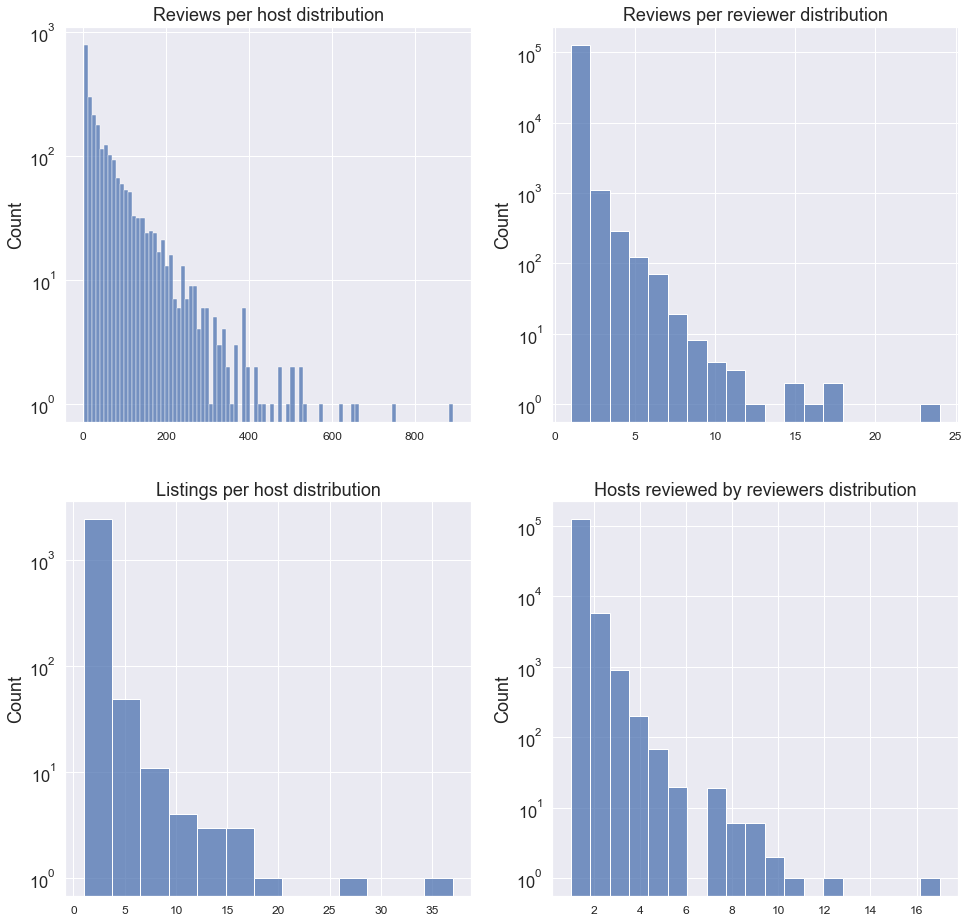

In [19]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

In [20]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(18, 12)

In [21]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep = False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], inplace=True)
subset.shape

(18, 12)

In [22]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  8
Number of hosts:  5


In [23]:
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

### Initial 2-Mode Network

In [24]:
subset.reviewer_id.nunique()

8

In [25]:
subset.host_id.nunique()

5

In [26]:
G = nx.Graph()
# Use bipartite 0 or 1 to denote which node it belongs to
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [27]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 8
Average degree:   1.2308


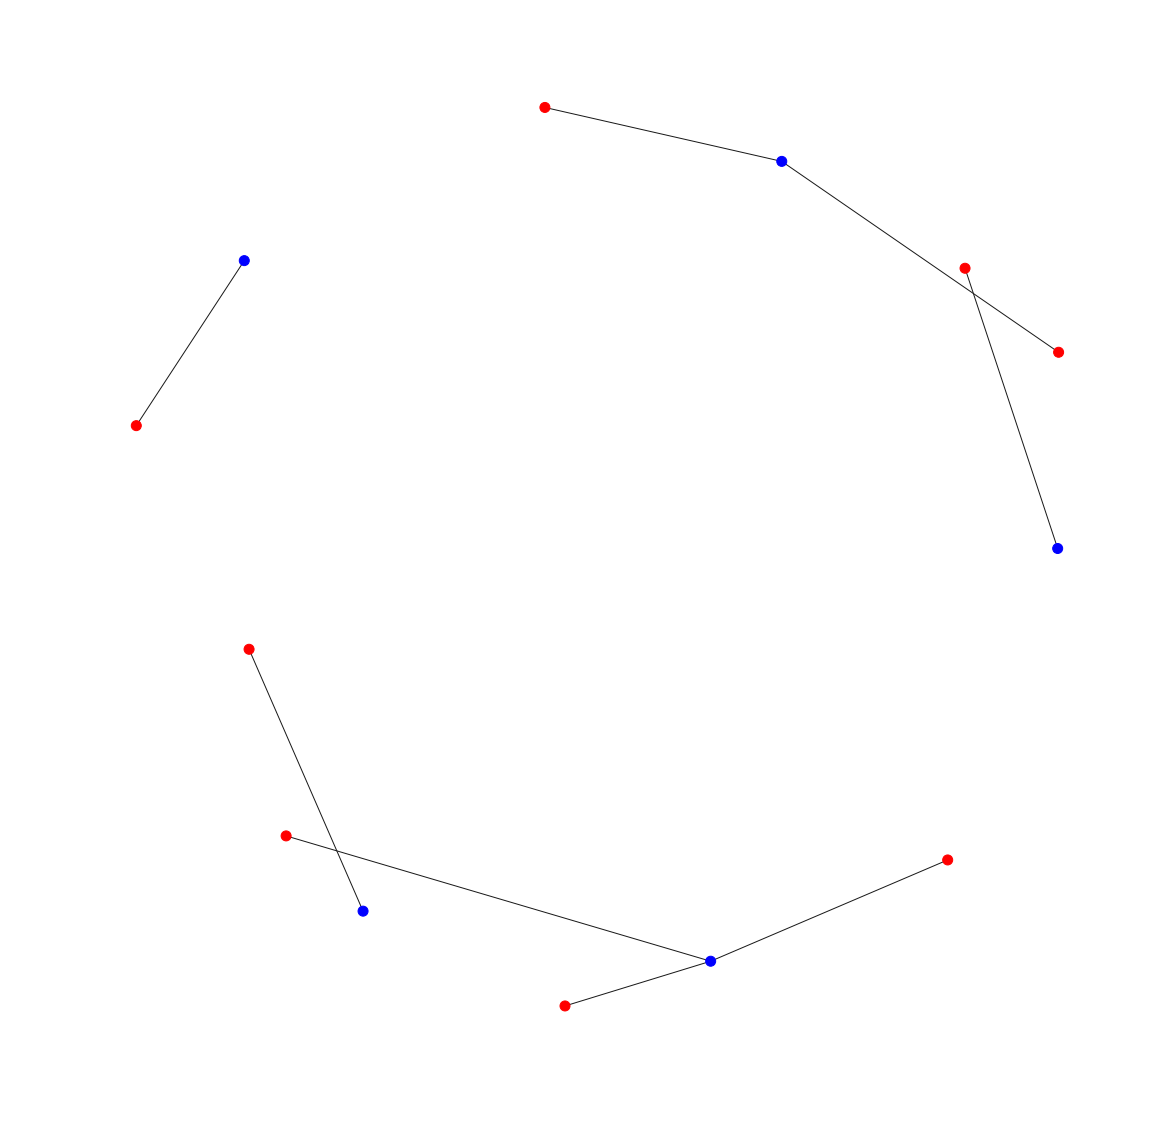

In [32]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Bipartite host graph

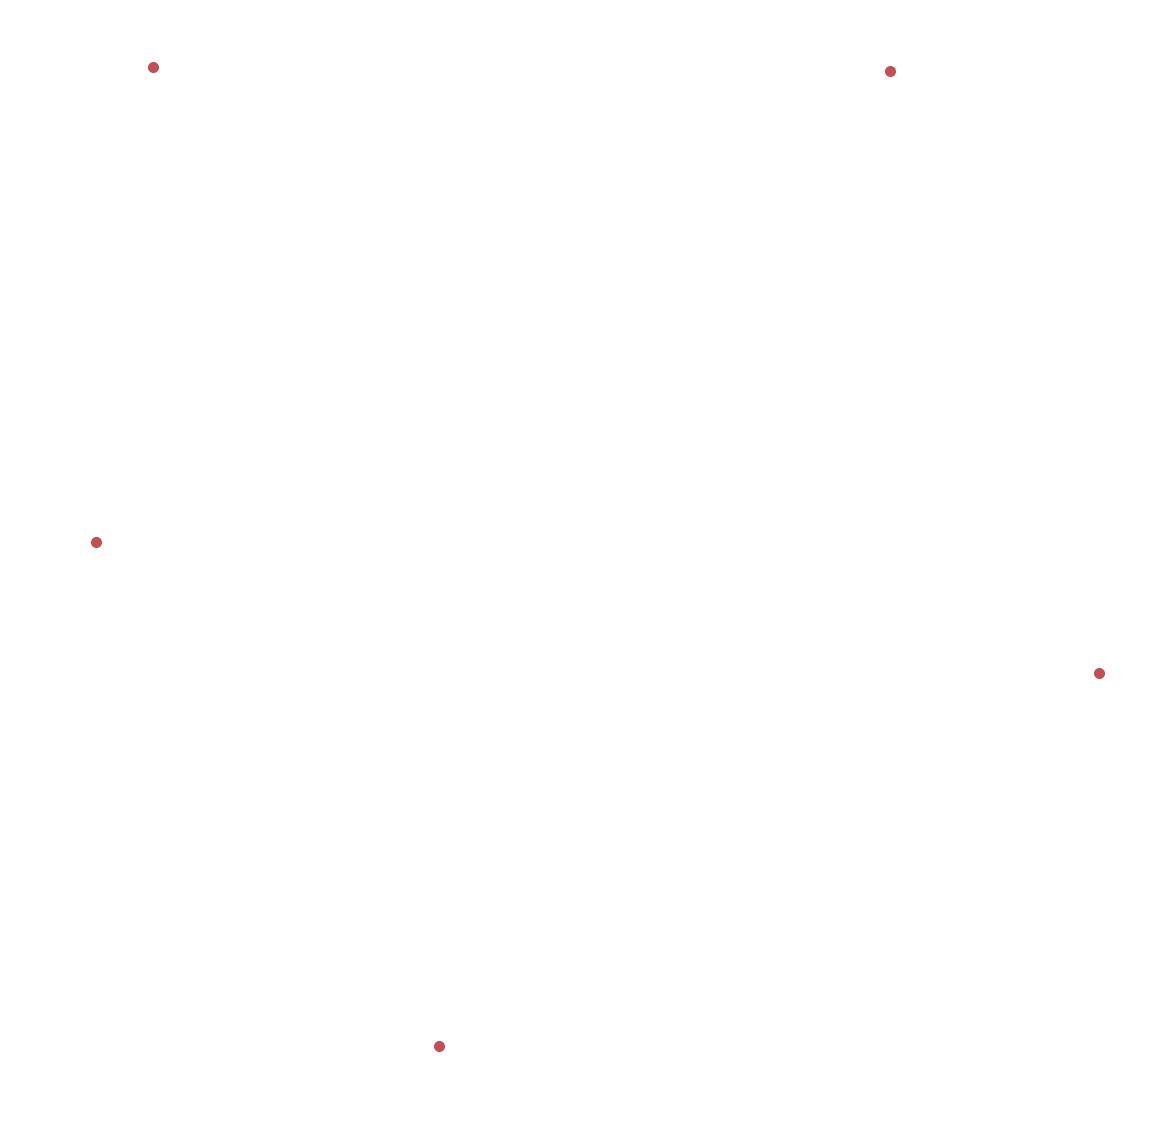

In [33]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique().tolist()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# create plot
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.6)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [34]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 5


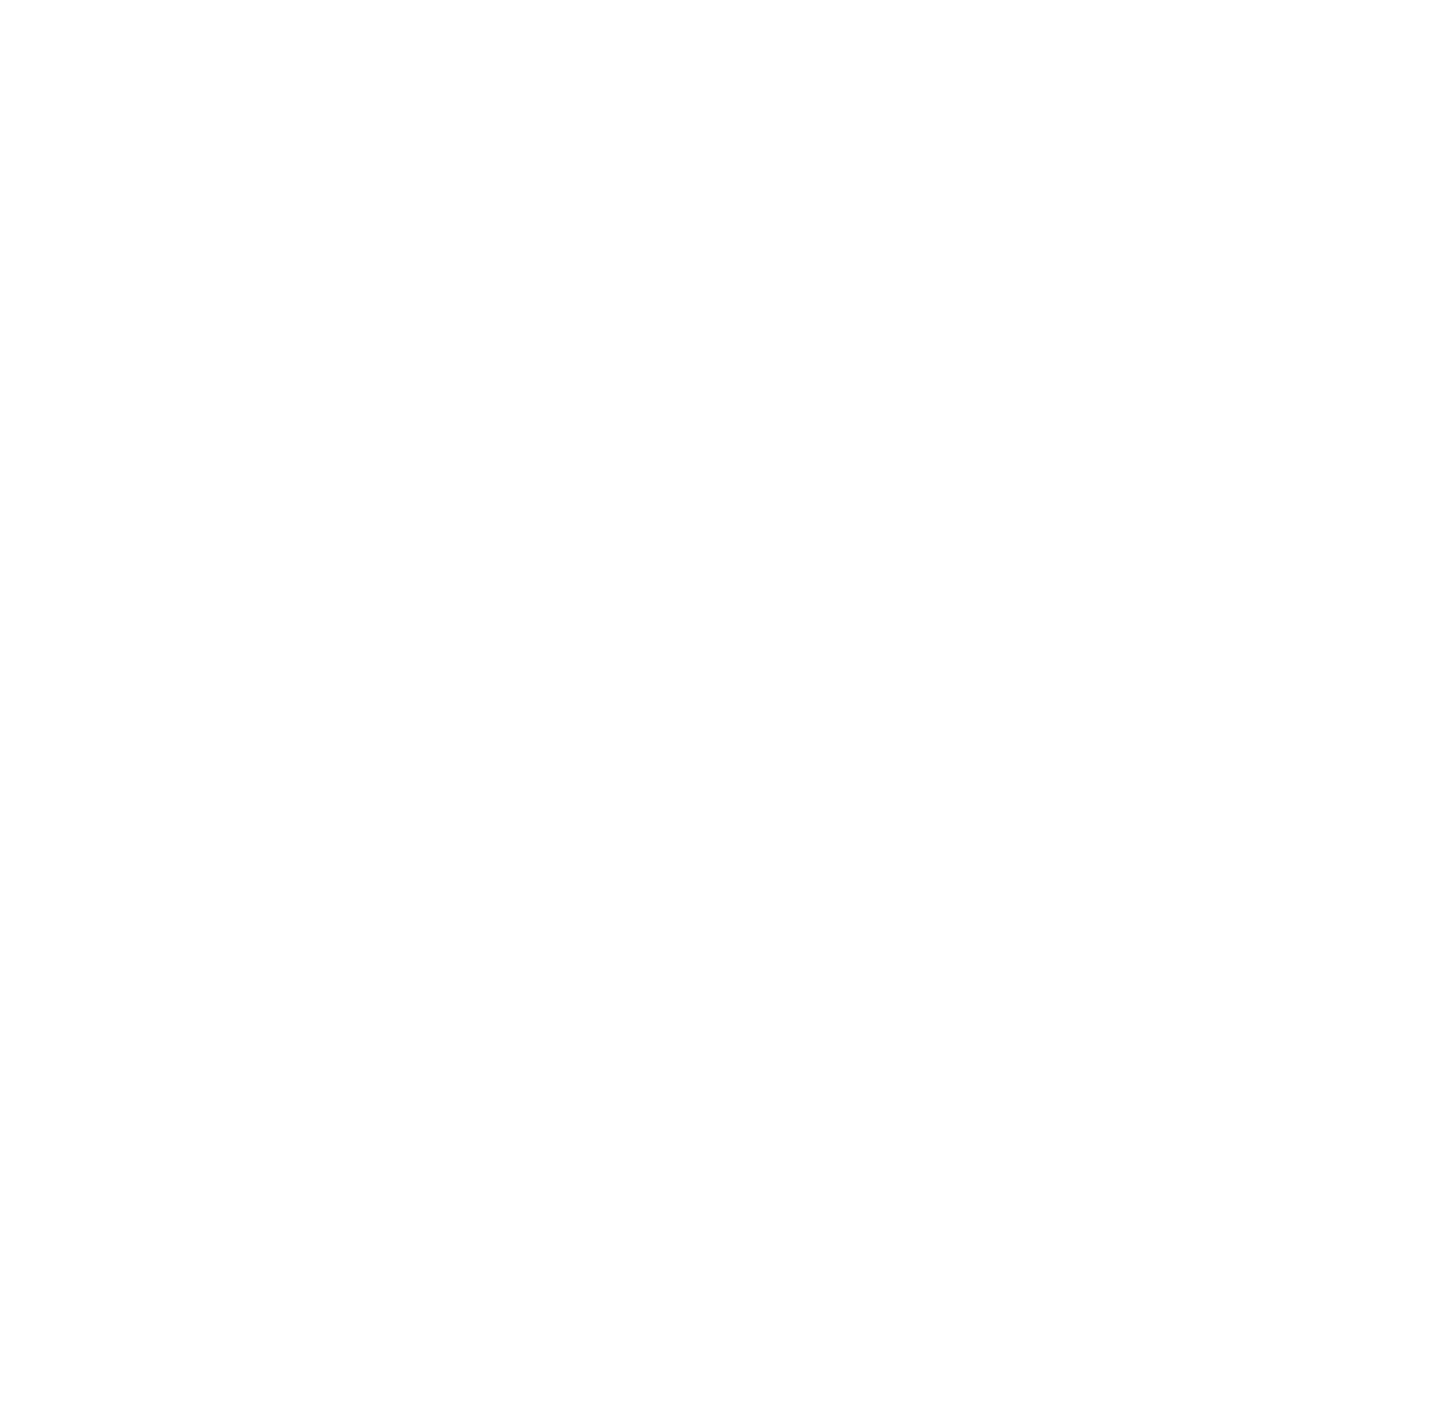

In [38]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(25,25))
# nx.draw_networkx(B, pos, with_labels=False, node_size=100)
nx.draw_networkx_nodes(B, pos, node_size=50)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.5)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()